# Import Packages

In [96]:
import numpy as np
import pandas as pd
from scripts import data_clean_utils
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer, MissingIndicator
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, MinMaxScaler, PowerTransformer, OrdinalEncoder
from sklearn.model_selection import train_test_split
from pathlib import Path

In [97]:
import dagshub
dagshub.init(repo_owner='kunal15cr', repo_name='Food-Delivery-Time-Prediction-API', mlflow=True)

Initialized MLflow to track repo "kunal15cr/Food-Delivery-Time-Prediction-API"

Repository kunal15cr/Food-Delivery-Time-Prediction-API initialized!

In [3]:
from sklearn import set_config

set_config(transform_output="pandas")

# Load the Data

In [4]:
BASE_DIR = Path().resolve().parent

DATA_PATH_DIR =  BASE_DIR / 'data' / 'raw' / 'swiggy.csv'



In [5]:
# load the data

df = pd.read_csv(DATA_PATH_DIR)

# Clean Data

In [8]:
clean_df = data_clean_utils.perform_data_cleaning(df)

In [9]:
clean_df.to_csv('swiggy_cleaned.csv', index=False)    

In [10]:
# load the cleaned data

df = pd.read_csv('swiggy_cleaned.csv')

df

,age,ratings,weather,traffic,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city_type,time_taken,is_weekend,pickup_time_minutes,order_time_of_day,distance,distance_type
0,37.0,4.9,sunny,high,2,snack,motorcycle,0.0,no,urban,24,1,15.0,morning,3.025149,short
1,34.0,4.5,stormy,jam,2,snack,scooter,1.0,no,metropolitian,33,0,5.0,evening,20.183530,very_long
2,23.0,4.4,sandstorms,low,0,drinks,motorcycle,1.0,no,urban,26,1,15.0,morning,1.552758,short
3,38.0,4.7,sunny,medium,0,buffet,motorcycle,1.0,no,metropolitian,21,0,10.0,evening,7.790401,medium
4,32.0,4.6,cloudy,high,1,snack,scooter,1.0,no,metropolitian,30,1,15.0,afternoon,6.210138,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43589,30.0,4.8,windy,high,1,meal,motorcycle,0.0,no,metropolitian,32,0,10.0,morning,1.489846,short
43590,21.0,4.6,windy,jam,0,buffet,motorcycle,1.0,no,metropolitian,36,0,15.0,evening,NaN,NaN
43591,30.0,4.9,cloudy,low,1,drinks,scooter,0.0,no,metropolitian,16,0,-1425.0,night,4.657195,short
43592,20.0,4.7,cloudy,high,0,snack,motorcycle,1.0,no,metropolitian,26,0,5.0,afternoon,6.232393,medium


In [11]:
df.columns

Index(['age', 'ratings', 'weather', 'traffic', 'vehicle_condition',
       'type_of_order', 'type_of_vehicle', 'multiple_deliveries', 'festival',
       'city_type', 'time_taken', 'is_weekend', 'pickup_time_minutes',
       'order_time_of_day', 'distance', 'distance_type'],
      dtype='object')

In [12]:
# drop columns not required for model input

columns_to_drop =  ['rider_id',
                    'restaurant_latitude',
                    'restaurant_longitude',
                    'delivery_latitude',
                    'delivery_longitude',
                    'order_date',
                    "order_time_hour",
                    "order_day",
                    "city_name",
                    "order_day_of_week",
                    "order_month"]

df.drop(columns=columns_to_drop, inplace=True)

df

KeyError: "['rider_id', 'restaurant_latitude', 'restaurant_longitude', 'delivery_latitude', 'delivery_longitude', 'order_date', 'order_time_hour', 'order_day', 'city_name', 'order_day_of_week', 'order_month'] not found in axis"

In [13]:
# check for missing values

df.isna().sum()

age                       0
ratings                   0
weather                   0
traffic                   0
vehicle_condition         0
type_of_order             0
type_of_vehicle           0
multiple_deliveries     933
festival                217
city_type              1135
time_taken                0
is_weekend                0
pickup_time_minutes       0
order_time_of_day       429
distance               3485
distance_type          3485
dtype: int64

In [14]:
# check for duplicates

df.duplicated().sum()

np.int64(0)

<Axes: >

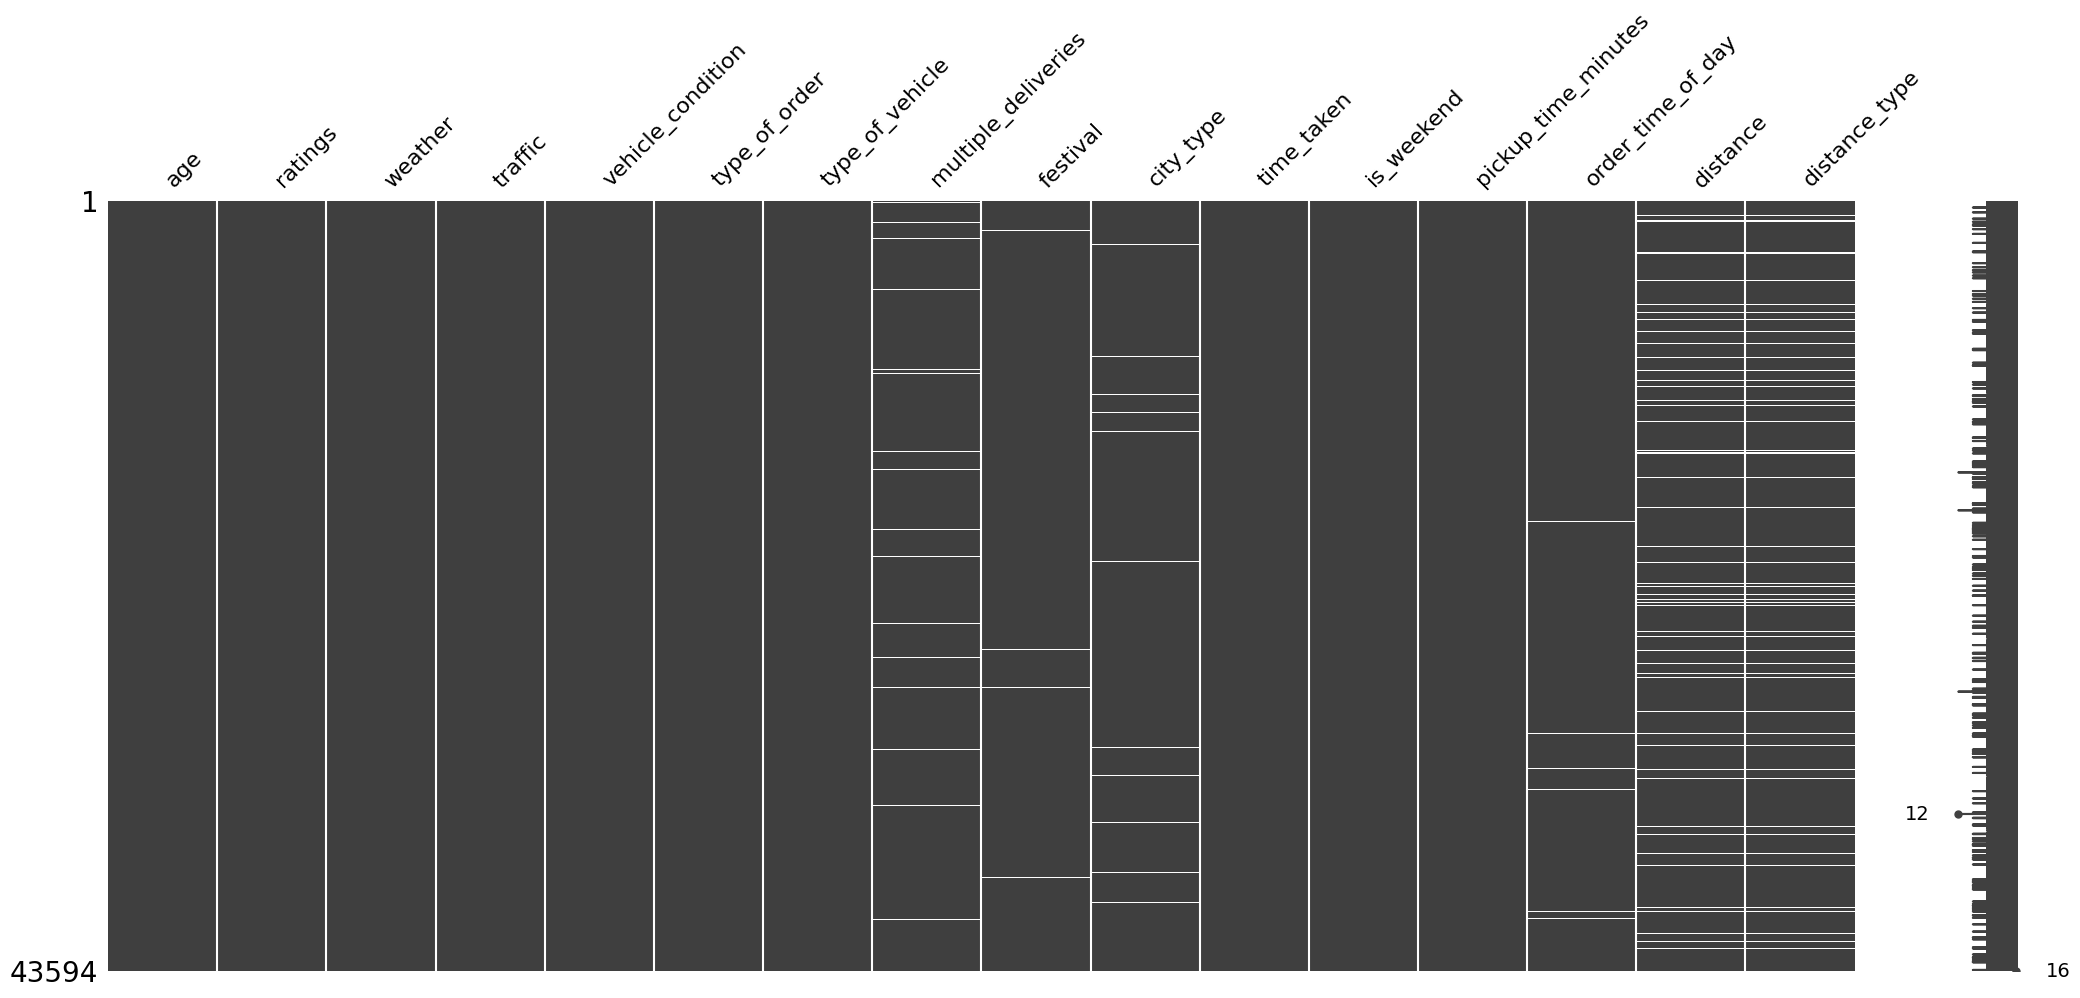

In [15]:
import missingno as msno

msno.matrix(df)

In [16]:
# columns that have missing values

missing_cols = (
                    df
                    .isna()
                    .any(axis=0)
                    .loc[lambda x: x]
                    .index
                )

missing_cols

Index(['multiple_deliveries', 'festival', 'city_type', 'order_time_of_day',
       'distance', 'distance_type'],
      dtype='object')

# Drop Missing Values



In [17]:
import mlflow

In [18]:
# set the tracking server

mlflow.set_tracking_uri("https://dagshub.com/kunal15cr/Food-Delivery-Time-Prediction-API.mlflow")

In [19]:
# mlflow experiment

mlflow.set_experiment("Exp 1 - Keep Vs Drop Missing Values")

<Experiment: artifact_location='mlflow-artifacts:/dff2e82de83a42838b7df1b35f73e539', creation_time=1766257854440, experiment_id='1', last_update_time=1766257854440, lifecycle_stage='active', name='Exp 1 - Keep Vs Drop Missing Values', tags={}>

In [20]:
temp_df = df.copy().dropna()

In [21]:
temp_df

,age,ratings,weather,traffic,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city_type,time_taken,is_weekend,pickup_time_minutes,order_time_of_day,distance,distance_type
0,37.0,4.9,sunny,high,2,snack,motorcycle,0.0,no,urban,24,1,15.0,morning,3.025149,short
1,34.0,4.5,stormy,jam,2,snack,scooter,1.0,no,metropolitian,33,0,5.0,evening,20.183530,very_long
2,23.0,4.4,sandstorms,low,0,drinks,motorcycle,1.0,no,urban,26,1,15.0,morning,1.552758,short
3,38.0,4.7,sunny,medium,0,buffet,motorcycle,1.0,no,metropolitian,21,0,10.0,evening,7.790401,medium
4,32.0,4.6,cloudy,high,1,snack,scooter,1.0,no,metropolitian,30,1,15.0,afternoon,6.210138,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43588,35.0,4.2,windy,jam,2,drinks,motorcycle,1.0,no,metropolitian,33,0,10.0,night,16.600272,very_long
43589,30.0,4.8,windy,high,1,meal,motorcycle,0.0,no,metropolitian,32,0,10.0,morning,1.489846,short
43591,30.0,4.9,cloudy,low,1,drinks,scooter,0.0,no,metropolitian,16,0,-1425.0,night,4.657195,short
43592,20.0,4.7,cloudy,high,0,snack,motorcycle,1.0,no,metropolitian,26,0,5.0,afternoon,6.232393,medium


In [23]:
# split into X and y

X = temp_df.drop(columns='time_taken')
y = temp_df['time_taken']

X

,age,ratings,weather,traffic,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city_type,is_weekend,pickup_time_minutes,order_time_of_day,distance,distance_type
0,37.0,4.9,sunny,high,2,snack,motorcycle,0.0,no,urban,1,15.0,morning,3.025149,short
1,34.0,4.5,stormy,jam,2,snack,scooter,1.0,no,metropolitian,0,5.0,evening,20.183530,very_long
2,23.0,4.4,sandstorms,low,0,drinks,motorcycle,1.0,no,urban,1,15.0,morning,1.552758,short
3,38.0,4.7,sunny,medium,0,buffet,motorcycle,1.0,no,metropolitian,0,10.0,evening,7.790401,medium
4,32.0,4.6,cloudy,high,1,snack,scooter,1.0,no,metropolitian,1,15.0,afternoon,6.210138,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43588,35.0,4.2,windy,jam,2,drinks,motorcycle,1.0,no,metropolitian,0,10.0,night,16.600272,very_long
43589,30.0,4.8,windy,high,1,meal,motorcycle,0.0,no,metropolitian,0,10.0,morning,1.489846,short
43591,30.0,4.9,cloudy,low,1,drinks,scooter,0.0,no,metropolitian,0,-1425.0,night,4.657195,short
43592,20.0,4.7,cloudy,high,0,snack,motorcycle,1.0,no,metropolitian,0,5.0,afternoon,6.232393,medium


In [24]:
# train test split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [25]:
print("The size of train data is",X_train.shape)
print("The shape of test data is",X_test.shape)

The size of train data is (30156, 15)
The shape of test data is (7539, 15)


In [26]:
y_train

8341     49
24195    31
32625    11
24945    24
35571    31
         ..
19434    30
7268     24
13048    15
1000     26
18214    28
Name: time_taken, Length: 30156, dtype: int64

In [27]:
# missing data in training data

X_train.isna().sum()

age                    0
ratings                0
weather                0
traffic                0
vehicle_condition      0
type_of_order          0
type_of_vehicle        0
multiple_deliveries    0
festival               0
city_type              0
is_weekend             0
pickup_time_minutes    0
order_time_of_day      0
distance               0
distance_type          0
dtype: int64

In [28]:
X_train.columns

Index(['age', 'ratings', 'weather', 'traffic', 'vehicle_condition',
       'type_of_order', 'type_of_vehicle', 'multiple_deliveries', 'festival',
       'city_type', 'is_weekend', 'pickup_time_minutes', 'order_time_of_day',
       'distance', 'distance_type'],
      dtype='object')

In [29]:
len(X_train.columns)

15

In [30]:
# do basic preprocessing

num_cols = ["age","ratings","pickup_time_minutes","distance"]

nominal_cat_cols = ['weather','type_of_order',
                    'type_of_vehicle',"festival",
                    "city_type",
                    "is_weekend",
                    "order_time_of_day"]

ordinal_cat_cols = ["traffic","distance_type"]

In [31]:
len(num_cols + nominal_cat_cols + ordinal_cat_cols)

13

In [32]:
X_train

,age,ratings,weather,traffic,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city_type,is_weekend,pickup_time_minutes,order_time_of_day,distance,distance_type
8341,29.0,3.9,sunny,jam,0,drinks,motorcycle,2.0,no,semi-urban,0,15.0,night,9.348069,medium
24195,39.0,4.4,sandstorms,medium,0,meal,motorcycle,1.0,no,metropolitian,1,5.0,afternoon,4.469606,short
32625,29.0,4.5,sunny,high,1,buffet,motorcycle,0.0,no,urban,0,10.0,morning,1.513073,short
24945,39.0,4.8,sandstorms,low,0,meal,motorcycle,1.0,no,metropolitian,1,15.0,night,10.445118,long
35571,30.0,4.4,windy,medium,1,buffet,scooter,1.0,no,metropolitian,1,10.0,afternoon,6.217834,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19434,31.0,4.8,sunny,jam,0,meal,motorcycle,0.0,no,metropolitian,1,10.0,evening,10.279024,long
7268,21.0,5.0,sandstorms,medium,1,snack,motorcycle,1.0,no,metropolitian,1,15.0,evening,13.407034,long
13048,30.0,4.8,cloudy,medium,1,snack,motorcycle,0.0,no,metropolitian,1,5.0,afternoon,7.762606,medium
1000,38.0,4.9,sunny,low,0,buffet,motorcycle,1.0,no,urban,1,10.0,morning,1.552561,short


In [33]:
for col in ordinal_cat_cols:
    print(col,X_train[col].unique())

traffic ['jam' 'medium' 'high' 'low']
distance_type ['medium' 'short' 'long' 'very_long']


In [34]:
# generate order for ordinal encoding

traffic_order = ["low","medium","high","jam"]

distance_type_order = ["short","medium","long","very_long"]

In [35]:
# build a preprocessor

preprocessor = ColumnTransformer(transformers=[
    ("scale", MinMaxScaler(), num_cols),
    ("nominal_encode", OneHotEncoder(drop="first",handle_unknown="ignore",sparse_output=False), nominal_cat_cols),
    ("ordinal_encode", OrdinalEncoder(categories=[traffic_order,distance_type_order]), ordinal_cat_cols)
],remainder="passthrough",n_jobs=-1,force_int_remainder_cols=False,verbose_feature_names_out=False)

preprocessor.set_output(transform="pandas")

,transformers,"[('scale', ...), ('nominal_encode', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,-1
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False
,force_int_remainder_cols,False
,feature_range,"(0, ...)"
,copy,True
,clip,False


In [36]:
# transform the data

X_train_trans = preprocessor.fit_transform(X_train)
X_test_trans = preprocessor.transform(X_test)

X_train_trans

d:\FInal project\Project 2\Food Delivery Time Prediction API\.venv\lib\site-packages\sklearn\compose\_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(


,age,ratings,pickup_time_minutes,distance,weather_fog,weather_sandstorms,weather_stormy,weather_sunny,weather_windy,type_of_order_drinks,...,city_type_semi-urban,city_type_urban,is_weekend_1,order_time_of_day_evening,order_time_of_day_morning,order_time_of_day_night,traffic,distance_type,vehicle_condition,multiple_deliveries
8341,0.473684,0.56,1.000000,0.404165,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,0,2.0
24195,1.000000,0.76,0.993103,0.154044,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,1.0
32625,0.473684,0.80,0.996552,0.002461,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1,0.0
24945,1.000000,0.92,1.000000,0.460411,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0,1.0
35571,0.526316,0.76,0.996552,0.243676,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19434,0.578947,0.92,0.996552,0.451895,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,3.0,2.0,0,0.0
7268,0.052632,1.00,1.000000,0.612270,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,2.0,1,1.0
13048,0.526316,0.92,0.993103,0.322877,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1,0.0
1000,0.947368,0.96,0.996552,0.004486,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0,1.0


In [37]:
# transform target column

pt = PowerTransformer()

y_train_pt = pt.fit_transform(y_train.values.reshape(-1,1))
y_test_pt = pt.transform(y_test.values.reshape(-1,1))

In [38]:
pt.lambdas_

array([0.32446095])

In [39]:
y_train_pt

,x0
0,2.028672
1,0.554539
2,-2.024267
3,-0.173699
4,0.554539
...,...
30151,0.457580
30152,-0.173699
30153,-1.350937
30154,0.047111


In [40]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()

rf.fit(X_train_trans,y_train_pt.values.ravel())

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [41]:
# get the predictions
y_pred_train = rf.predict(X_train_trans)
y_pred_test = rf.predict(X_test_trans)

In [42]:
# get the actual predictions values

y_pred_train_org = pt.inverse_transform(y_pred_train.reshape(-1,1))
y_pred_test_org = pt.inverse_transform(y_pred_test.reshape(-1,1))

In [43]:
from sklearn.metrics import mean_absolute_error, r2_score

print(f"The train error is {mean_absolute_error(y_train,y_pred_train_org):.2f} minutes")
print(f"The test error is {mean_absolute_error(y_test,y_pred_test_org):.2f} minutes")

The train error is 1.15 minutes
The test error is 3.10 minutes


In [44]:
print(f"The train r2 score is {r2_score(y_train,y_pred_train_org):.2f}")
print(f"The test r2 score is {r2_score(y_test,y_pred_test_org):.2f}")

The train r2 score is 0.98
The test r2 score is 0.83


In [48]:
# calculate the cross val score

from sklearn.model_selection import cross_val_score

scores = cross_val_score(rf,X_train_trans,y_train_pt.values.ravel(),cv=5,scoring="r2",n_jobs=-1)

scores

array([0.80847335, 0.81013159, 0.81069008, 0.80894416, 0.81070476])

In [49]:
# mean score

scores.mean()

np.float64(0.8097887887959425)

<Axes: >

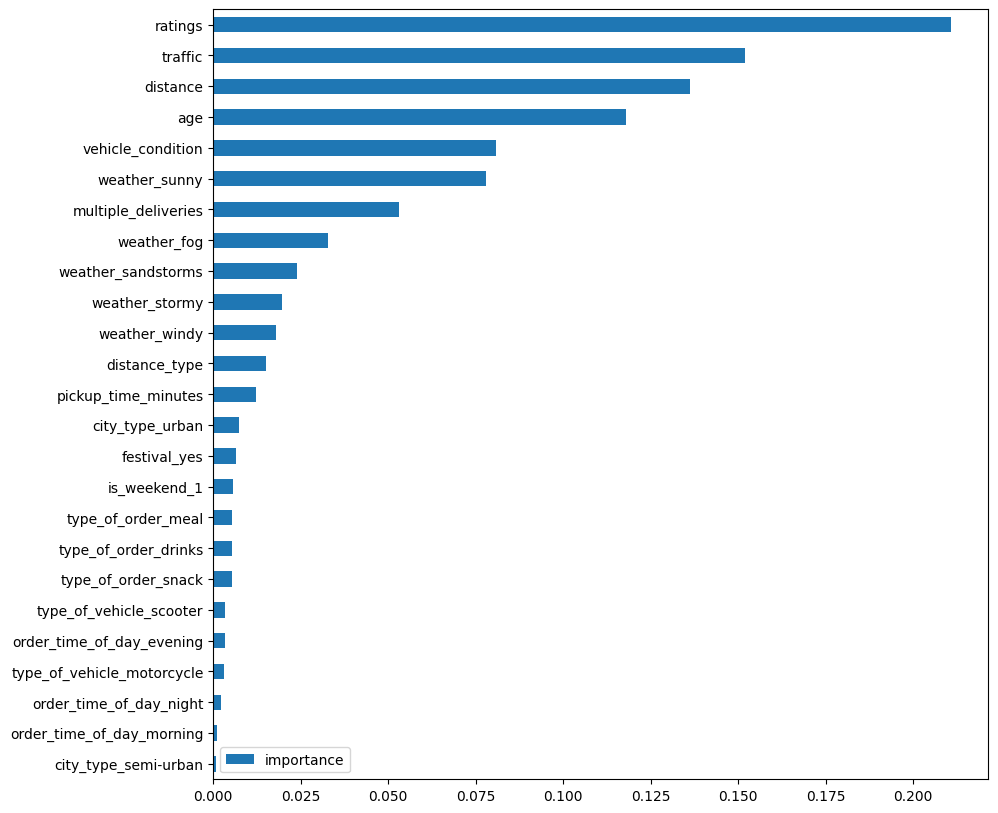

In [50]:
# feature importance plot

(
    pd.DataFrame(rf.feature_importances_,
             index=X_train_trans.columns,
             columns=["importance"])
    .sort_values(by="importance")
    .plot(kind='barh',figsize=(10,10))
)

In [51]:
# log experiment

with mlflow.start_run(run_name="Drop Missing Values"):
    # mlflow log experiment type
    mlflow.log_param("experiment_type","Drop Missing Values")
    # log model params
    mlflow.log_params(rf.get_params())

    # log metrics
    mlflow.log_metric("training_error",mean_absolute_error(y_train,y_pred_train_org))
    mlflow.log_metric("test_error",mean_absolute_error(y_test,y_pred_test_org))
    mlflow.log_metric("training_r2",r2_score(y_train,y_pred_train_org))
    mlflow.log_metric("test_r2",r2_score(y_test,y_pred_test_org))
    mlflow.log_metric("cross_val",scores.mean())


🏃 View run Drop Missing Values at: https://dagshub.com/kunal15cr/Food-Delivery-Time-Prediction-API.mlflow/#/experiments/1/runs/ae406b8a058c4ef9830e57be1e0450b3
🧪 View experiment at: https://dagshub.com/kunal15cr/Food-Delivery-Time-Prediction-API.mlflow/#/experiments/1


In [52]:
from sklearn.feature_selection import RFECV

In [53]:
# feature selection using rfecv

rfecv = RFECV(
    estimator=rf,
    step=10,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=2
)

In [54]:
# select features

rfecv.fit(X_train_trans,y_train_pt.values.ravel())

,estimator,RandomForestRegressor()
,step,10
,min_features_to_select,1
,cv,5
,scoring,'r2'
,verbose,2
,n_jobs,-1
,importance_getter,'auto'
,n_estimators,100
,criterion,'squared_error'
,max_depth,None


In [55]:
# list of selected features

rfecv.get_feature_names_out()

array(['age', 'ratings', 'pickup_time_minutes', 'distance', 'weather_fog',
       'weather_sandstorms', 'weather_stormy', 'weather_sunny',
       'weather_windy', 'type_of_order_drinks', 'type_of_order_meal',
       'type_of_order_snack', 'type_of_vehicle_motorcycle',
       'type_of_vehicle_scooter', 'festival_yes', 'city_type_semi-urban',
       'city_type_urban', 'is_weekend_1', 'order_time_of_day_evening',
       'order_time_of_day_morning', 'order_time_of_day_night', 'traffic',
       'distance_type', 'vehicle_condition', 'multiple_deliveries'],
      dtype=object)

In [56]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()

rf.fit(rfecv.transform(X_train_trans),y_train_pt.values.ravel())

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [57]:
# get the predictions
y_pred_train = rf.predict(rfecv.transform(X_train_trans))
y_pred_test = rf.predict(rfecv.transform(X_test_trans))

In [58]:
# get the actual predictions values

y_pred_train_org = pt.inverse_transform(y_pred_train.reshape(-1,1))
y_pred_test_org = pt.inverse_transform(y_pred_test.reshape(-1,1))

In [59]:
from sklearn.metrics import mean_absolute_error, r2_score

print(f"The train error is {mean_absolute_error(y_train,y_pred_train_org):.2f} minutes")
print(f"The test error is {mean_absolute_error(y_test,y_pred_test_org):.2f} minutes")

The train error is 1.15 minutes
The test error is 3.09 minutes


In [60]:
print(f"The train r2 score is {r2_score(y_train,y_pred_train_org):.2f}")
print(f"The test r2 score is {r2_score(y_test,y_pred_test_org):.2f}")

The train r2 score is 0.98
The test r2 score is 0.83


In [61]:
# calculate the cross val score

from sklearn.model_selection import cross_val_score

scores = cross_val_score(rf,rfecv.transform(X_train_trans),y_train_pt.values.ravel(),cv=5,scoring="r2",n_jobs=-1)

scores

array([0.80720089, 0.81065333, 0.81063678, 0.80990721, 0.81117135])

In [62]:
# mean score

scores.mean()

np.float64(0.8099139118634435)

In [63]:
rf.feature_importances_

array([0.11977836, 0.21079012, 0.01215387, 0.13745532, 0.03356933,
       0.02446582, 0.01934218, 0.08013531, 0.01849257, 0.00543328,
       0.00543853, 0.00529691, 0.00305858, 0.00338779, 0.00624959,
       0.00078206, 0.0073138 , 0.00575682, 0.00316687, 0.00116604,
       0.00226289, 0.15162554, 0.0140119 , 0.08167341, 0.0471931 ])

<Axes: >

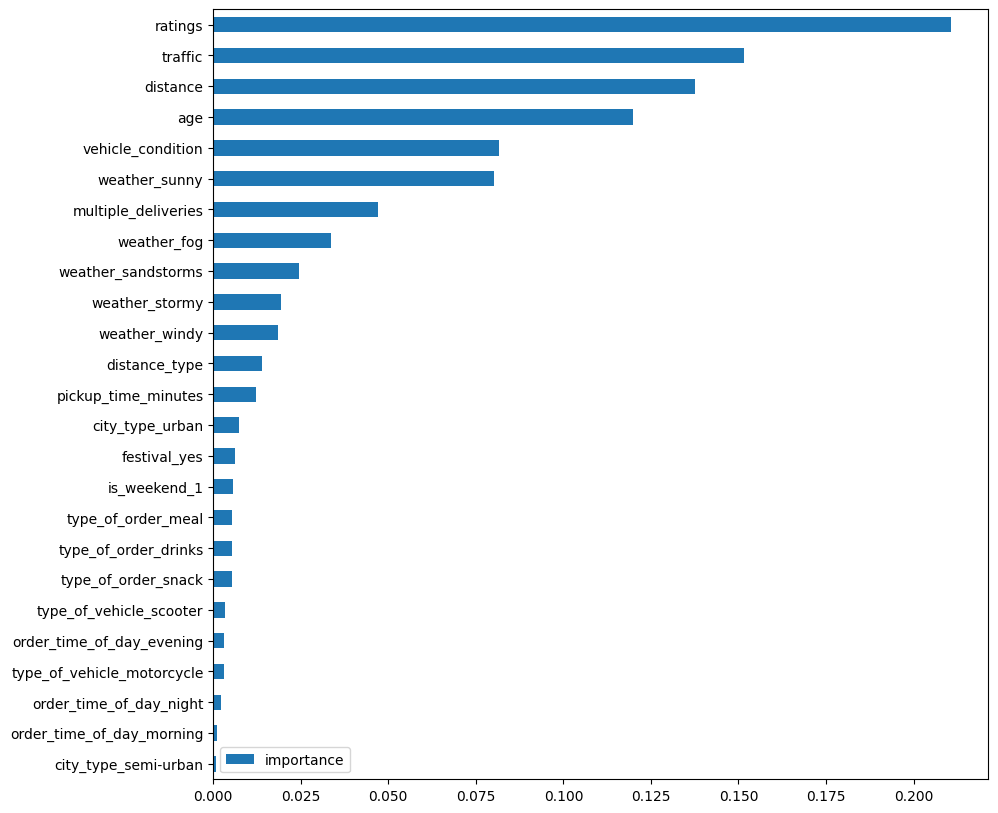

In [64]:
# feature importance plot

(
    pd.DataFrame(rf.feature_importances_,
             index=rfecv.transform(X_train_trans).columns,
             columns=["importance"])
    .sort_values(by="importance")
    .plot(kind='barh',figsize=(10,10))
)

# Impute Missing values

In [65]:
temp_df = df.copy()

In [66]:
# split into X and y

X = temp_df.drop(columns='time_taken')
y = temp_df['time_taken']

X

,age,ratings,weather,traffic,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city_type,is_weekend,pickup_time_minutes,order_time_of_day,distance,distance_type
0,37.0,4.9,sunny,high,2,snack,motorcycle,0.0,no,urban,1,15.0,morning,3.025149,short
1,34.0,4.5,stormy,jam,2,snack,scooter,1.0,no,metropolitian,0,5.0,evening,20.183530,very_long
2,23.0,4.4,sandstorms,low,0,drinks,motorcycle,1.0,no,urban,1,15.0,morning,1.552758,short
3,38.0,4.7,sunny,medium,0,buffet,motorcycle,1.0,no,metropolitian,0,10.0,evening,7.790401,medium
4,32.0,4.6,cloudy,high,1,snack,scooter,1.0,no,metropolitian,1,15.0,afternoon,6.210138,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43589,30.0,4.8,windy,high,1,meal,motorcycle,0.0,no,metropolitian,0,10.0,morning,1.489846,short
43590,21.0,4.6,windy,jam,0,buffet,motorcycle,1.0,no,metropolitian,0,15.0,evening,NaN,NaN
43591,30.0,4.9,cloudy,low,1,drinks,scooter,0.0,no,metropolitian,0,-1425.0,night,4.657195,short
43592,20.0,4.7,cloudy,high,0,snack,motorcycle,1.0,no,metropolitian,0,5.0,afternoon,6.232393,medium


In [67]:
# train test split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [68]:
print("The size of train data is",X_train.shape)
print("The shape of test data is",X_test.shape)

The size of train data is (34875, 15)
The shape of test data is (8719, 15)


In [69]:
# missing values in train data

X_train.isna().sum()

age                       0
ratings                   0
weather                   0
traffic                   0
vehicle_condition         0
type_of_order             0
type_of_vehicle           0
multiple_deliveries     756
festival                171
city_type               921
is_weekend                0
pickup_time_minutes       0
order_time_of_day       337
distance               2768
distance_type          2768
dtype: int64

In [70]:
# transform target column

pt = PowerTransformer()

y_train_pt = pt.fit_transform(y_train.values.reshape(-1,1))
y_test_pt = pt.transform(y_test.values.reshape(-1,1))

In [71]:
missing_cols

Index(['multiple_deliveries', 'festival', 'city_type', 'order_time_of_day',
       'distance', 'distance_type'],
      dtype='object')

In [72]:
# percentage of rows in data having missing values

(
    X_train
    .isna()
    .any(axis=1)
    .mean()
    .round(2) * 100
)


np.float64(13.0)

# Imputation Pipeline

In [73]:
nominal_cat_cols

['weather',
 'type_of_order',
 'type_of_vehicle',
 'festival',
 'city_type',
 'is_weekend',
 'order_time_of_day']

In [74]:
X_train.isna().sum()

age                       0
ratings                   0
weather                   0
traffic                   0
vehicle_condition         0
type_of_order             0
type_of_vehicle           0
multiple_deliveries     756
festival                171
city_type               921
is_weekend                0
pickup_time_minutes       0
order_time_of_day       337
distance               2768
distance_type          2768
dtype: int64

In [75]:
# features to fill values with mode

features_to_fill_mode = ['multiple_deliveries','festival','city_type']
features_to_fill_missing = [col for col in nominal_cat_cols if col not in features_to_fill_mode]

features_to_fill_missing

['weather',
 'type_of_order',
 'type_of_vehicle',
 'is_weekend',
 'order_time_of_day']

In [76]:
# simple imputer to fill categorical vars with mode

simple_imputer = ColumnTransformer(transformers=[
    ("mode_imputer",SimpleImputer(strategy="most_frequent"),features_to_fill_mode),
    ("missing_imputer",SimpleImputer(strategy="constant",fill_value="missing"),features_to_fill_missing)
],remainder="passthrough",n_jobs=-1,force_int_remainder_cols=False,verbose_feature_names_out=False)

simple_imputer

,transformers,"[('mode_imputer', ...), ('missing_imputer', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,-1
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False
,force_int_remainder_cols,False
,missing_values,nan
,strategy,'most_frequent'
,fill_value,None


In [77]:
simple_imputer.fit_transform(X_train)

d:\FInal project\Project 2\Food Delivery Time Prediction API\.venv\lib\site-packages\sklearn\compose\_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(


,multiple_deliveries,festival,city_type,weather,type_of_order,type_of_vehicle,is_weekend,order_time_of_day,age,ratings,traffic,vehicle_condition,pickup_time_minutes,distance,distance_type
3938,0.0,no,metropolitian,sunny,drinks,motorcycle,1,afternoon,20.0,4.8,medium,1,5.0,8.953006,medium
3252,1.0,no,metropolitian,sunny,buffet,scooter,0,night,38.0,4.4,jam,2,10.0,17.098061,very_long
40782,0.0,no,metropolitian,stormy,drinks,motorcycle,0,morning,34.0,4.4,low,0,15.0,3.108984,short
41197,1.0,no,metropolitian,sandstorms,buffet,scooter,1,morning,25.0,5.0,low,1,15.0,1.552700,short
1510,1.0,no,metropolitian,cloudy,snack,scooter,0,morning,20.0,5.0,high,2,15.0,3.064487,short
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,0.0,no,urban,cloudy,drinks,motorcycle,1,night,22.0,4.7,low,0,-1425.0,10.866262,long
11284,1.0,no,metropolitian,cloudy,drinks,scooter,0,evening,28.0,4.8,jam,2,10.0,12.255818,long
38158,2.0,no,metropolitian,cloudy,meal,motorcycle,0,evening,28.0,5.0,medium,0,5.0,10.703215,long
860,1.0,no,urban,windy,snack,motorcycle,1,morning,38.0,4.8,low,1,5.0,1.532253,short


In [78]:
simple_imputer.fit_transform(X_train).isna().sum()

d:\FInal project\Project 2\Food Delivery Time Prediction API\.venv\lib\site-packages\sklearn\compose\_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(


multiple_deliveries       0
festival                  0
city_type                 0
weather                   0
type_of_order             0
type_of_vehicle           0
is_weekend                0
order_time_of_day         0
age                       0
ratings                   0
traffic                   0
vehicle_condition         0
pickup_time_minutes       0
distance               2768
distance_type          2768
dtype: int64

In [79]:
# knn imputer

knn_imputer = KNNImputer(n_neighbors=5)

In [80]:
# do basic preprocessing

num_cols = ["age","ratings","pickup_time_minutes","distance"]

nominal_cat_cols = ['weather','type_of_order',
                    'type_of_vehicle',"festival",
                    "city_type",
                    "is_weekend",
                    "order_time_of_day"]

ordinal_cat_cols = ["traffic","distance_type"]

In [81]:
# generate order for ordinal encoding

traffic_order = ["low","medium","high","jam"]

distance_type_order = ["short","medium","long","very_long"]

In [82]:
# unique categories the ordinal columns

for col in ordinal_cat_cols:
    print(col,X_train[col].unique())

traffic ['medium' 'jam' 'low' 'high']
distance_type ['medium' 'very_long' 'short' 'long' nan]


In [83]:
# build a preprocessor

preprocessor = ColumnTransformer(transformers=[
    ("scale", MinMaxScaler(), num_cols),
    ("nominal_encode", OneHotEncoder(drop="first",handle_unknown="ignore",
                                     sparse_output=False), nominal_cat_cols),
    ("ordinal_encode", OrdinalEncoder(categories=[traffic_order,distance_type_order],
                                      encoded_missing_value=-999,
                                      handle_unknown="use_encoded_value",
                                      unknown_value=-1), ordinal_cat_cols)
],remainder="passthrough",n_jobs=-1,force_int_remainder_cols=False,verbose_feature_names_out=False)


preprocessor

,transformers,"[('scale', ...), ('nominal_encode', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,-1
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False
,force_int_remainder_cols,False
,feature_range,"(0, ...)"
,copy,True
,clip,False


In [84]:
preprocessor.fit_transform(X_train)

d:\FInal project\Project 2\Food Delivery Time Prediction API\.venv\lib\site-packages\sklearn\compose\_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(


,age,ratings,pickup_time_minutes,distance,weather_fog,weather_sandstorms,weather_stormy,weather_sunny,weather_windy,type_of_order_drinks,...,city_type_nan,is_weekend_1,order_time_of_day_evening,order_time_of_day_morning,order_time_of_day_night,order_time_of_day_nan,traffic,distance_type,vehicle_condition,multiple_deliveries
3938,0.000000,0.92,0.993103,0.383910,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1,0.0
3252,0.947368,0.76,0.996552,0.801510,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,3.0,3.0,2,1.0
40782,0.736842,0.76,1.000000,0.084284,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0.0
41197,0.263158,1.00,1.000000,0.004493,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1,1.0
1510,0.000000,1.00,1.000000,0.082003,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,2,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,0.105263,0.88,0.006897,0.482003,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0,0,0.0
11284,0.421053,0.92,0.996552,0.553246,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,3.0,2.0,2,1.0
38158,0.421053,1.00,0.993103,0.473644,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,0,2.0
860,0.947368,0.92,0.993103,0.003445,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1,1.0


In [85]:
preprocessor.fit_transform(X_train).isna().sum().loc[lambda ser : ser.ge(1)]

d:\FInal project\Project 2\Food Delivery Time Prediction API\.venv\lib\site-packages\sklearn\compose\_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(


distance               2768
multiple_deliveries     756
dtype: int64

In [86]:
# build the pipeline

processing_pipeline = Pipeline(steps=[
                                ("simple_imputer",simple_imputer),
                                ("preprocess",preprocessor),
                                ("knn_imputer",knn_imputer)
                            ])

processing_pipeline

,steps,"[('simple_imputer', ...), ('preprocess', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('mode_imputer', ...), ('missing_imputer', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,-1
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


In [87]:
model_pipe = Pipeline(steps=[
                                ("preprocessing",processing_pipeline),
                                ("model",rf)
                            ])

model_pipe

,steps,"[('preprocessing', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,steps,"[('simple_imputer', ...), ('preprocess', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('mode_imputer', ...), ('missing_imputer', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3


In [88]:
# fit the pipeline on data

model_pipe.fit(X_train,y_train_pt.values.ravel())

d:\FInal project\Project 2\Food Delivery Time Prediction API\.venv\lib\site-packages\sklearn\compose\_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(
d:\FInal project\Project 2\Food Delivery Time Prediction API\.venv\lib\site-packages\sklearn\compose\_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(


,steps,"[('preprocessing', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,steps,"[('simple_imputer', ...), ('preprocess', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('mode_imputer', ...), ('missing_imputer', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3


In [89]:
# get the predictions
y_pred_train = model_pipe.predict(X_train)
y_pred_test = model_pipe.predict(X_test)

In [90]:
# get the actual predictions values

y_pred_train_org = pt.inverse_transform(y_pred_train.reshape(-1,1))
y_pred_test_org = pt.inverse_transform(y_pred_test.reshape(-1,1))

In [91]:
from sklearn.metrics import mean_absolute_error, r2_score

print(f"The train error is {mean_absolute_error(y_train,y_pred_train_org):.2f} minutes")
print(f"The test error is {mean_absolute_error(y_test,y_pred_test_org):.2f} minutes")

The train error is 1.18 minutes
The test error is 3.17 minutes


In [92]:
print(f"The train r2 score is {r2_score(y_train,y_pred_train_org):.2f}")
print(f"The test r2 score is {r2_score(y_test,y_pred_test_org):.2f}")

The train r2 score is 0.97
The test r2 score is 0.82


In [93]:
# calculate the cross val score

from sklearn.model_selection import cross_val_score

scores = cross_val_score(model_pipe,X_train,y_train_pt.values.ravel(),cv=5,scoring="r2",n_jobs=-1)

scores

array([0.80360961, 0.79524458, 0.79448454, 0.79743104, 0.79627236])

In [94]:
# mean score

scores.mean()

np.float64(0.797408426424597)

In [95]:
# log experiment

with mlflow.start_run(run_name="Impute Missing Values"):
    # mlflow log experiment type
    mlflow.log_param("experiment_type","Impute Missing Values")
    # log model params
    mlflow.log_params(rf.get_params())

    # log metrics
    mlflow.log_metric("training_error",mean_absolute_error(y_train,y_pred_train_org))
    mlflow.log_metric("test_error",mean_absolute_error(y_test,y_pred_test_org))
    mlflow.log_metric("training_r2",r2_score(y_train,y_pred_train_org))
    mlflow.log_metric("test_r2",r2_score(y_test,y_pred_test_org))
    mlflow.log_metric("cross_val",scores.mean())

🏃 View run Impute Missing Values at: https://dagshub.com/kunal15cr/Food-Delivery-Time-Prediction-API.mlflow/#/experiments/1/runs/b261bda7345f4b76b8e9dc480a3d6817
🧪 View experiment at: https://dagshub.com/kunal15cr/Food-Delivery-Time-Prediction-API.mlflow/#/experiments/1
